In [41]:
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

In [42]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [119]:
df_train = pd.read_csv("./dataset/train.csv")
df_test  = pd.read_csv("./dataset/test.csv")

# Exploratory data analysis

In [44]:
df_train.shape, df_test.shape

((9146, 10), (36584, 9))

In [45]:
df_train.head(5)

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


<AxesSubplot:>

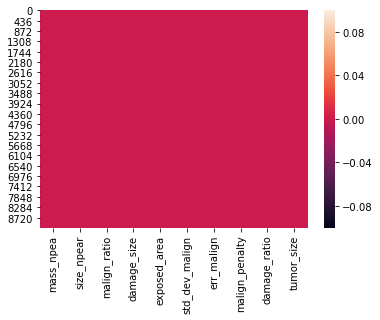

In [46]:
# null heatmap of training data
sns.heatmap(df_train.isnull())

Text(0.5, 1.0, 'Correlation heat map')

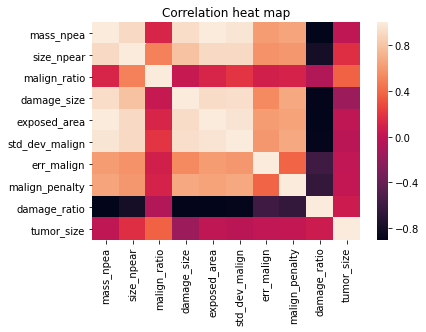

In [47]:
# correltaion heatmap 
sns.heatmap(df_train.corr()).set_title("Correlation heat map")

# data preprocessing

In [131]:
def preprocess(df):
#     df["density"] = df["mass_npea"].values/df["size_npear"].values
#     df.drop(["mass_npea"], axis = 1, inplace = True)
#     df["total_error"] = df["err_malign"].values + df["malign_penalty"].values
    df.drop(["err_malign", "malign_penalty"], axis = 1, inplace = True)
    return df
    

In [132]:
df_train = preprocess(df_train)

<AxesSubplot:>

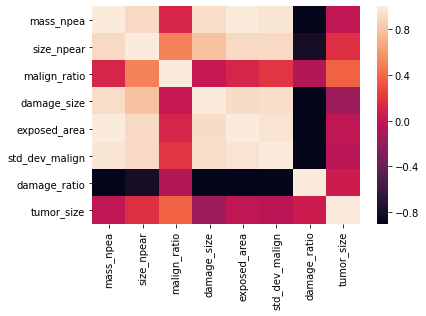

In [133]:
sns.heatmap(df_train.corr())

In [134]:
df_train.head(5)

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,35.0200,18.023


# checking for linearly seperable of data using SVM

In [ ]:
from sklearn import svm, datasets
from sklearn.preprocessing import MinMaxScaler
X_ls = df_train[["damage_size", "damage_ratio"]].iloc[:100]
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_ls)
X_ls = scaling.transform(X_ls)


# X_ls["damage_size"] = X_ls["damage_size"].astype(int)
# X_ls["damage_ratio"] = X_ls["damage_ratio"].astype(int)

y_ls = df_train["tumor_size"].astype(int).iloc[:100]

C = 2**32
svc = svm.SVC(kernel='linear', C = 2**32,gamma="auto").fit(X_ls, y_ls)

# create a mesh to plot in
x_min, x_max = X_ls[:, 0].min() - 1, X_ls[:, 0].max() + 1
y_min, y_max = X_ls[:, 1].min() - 1, X_ls[:, 1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

plt.subplot(1, 1, 1)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

plt.scatter(X_ls[:, 0], X_ls[:, 1], c=y_ls, cmap=plt.cm.Paired)
plt.xlabel('damage_size')
plt.ylabel('damage_ratio')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()


# Train test split 

In [140]:
X = df_train.drop(["tumor_size"], axis =1).values
y = df_train["tumor_size"].values

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [142]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6859, 7), (2287, 7), (6859,), (2287,))

# creating tensors

In [138]:

# prepraing the dataset
X_train = torch. FloatTensor(X_train)
X_test  = torch.FloatTensor(X_test)
y_train  = torch.FloatTensor(y_train)
y_test  = torch.FloatTensor(y_test)

# Model 1: ANN regression(pytorch)

In [56]:
# importing pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import imageio

In [57]:
# randomizing the initial weights
torch.manual_seed(1)    # reproducible

In [71]:
#model creation
class Net(torch.nn.Module):
    def __init__(self, input_features = 8, hidden1 = 6, hidden2 = 6, output_features = 1):
#         inheriting from the parent class nn.Module
        super().__init__()
        self.fully_connected1 = nn.Linear(input_features, hidden1)
        self.fully_connected2 = nn.Linear(hidden1, hidden2)
        self.predict = nn.Linear(hidden2, output_features)
    def forward(self, x):
        x = F.relu(self.fully_connected1(x))      # activation function for hidden layer
        x = F.relu(self.fully_connected2(x))
        x = self.predict(x)             # linear output
        return x
        

In [72]:
# model compilation
model = Net()

In [73]:
model.parameters

<bound method Module.parameters of Net(
  (fully_connected1): Linear(in_features=8, out_features=6, bias=True)
  (fully_connected2): Linear(in_features=6, out_features=6, bias=True)
  (predict): Linear(in_features=6, out_features=1, bias=True)
)>

In [89]:
#####backward propogation
#  definign the loss function and optimzer
loss_function = torch.nn.MSELoss()  # this is for regression mean squared loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

Training the  model

In [90]:
epochs = 200
final_losses = []
for i in range(epochs):
#     adjust_learning_rate(optimizer, i)
    predictions = model.forward(X_train)
    loss = loss_function(predictions, y_train)
    final_losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    # doing the backpropogation process 
    optimizer.step()
    if i%30==1:
        
        print("Epoch number: {} and the loss : {} with learning rate {}".format(i,loss.item(), optimizer.param_groups[0]["lr"]))

    
    
    

Epoch number: 1 and the loss : 36.872623443603516 with learning rate 0.01
Epoch number: 31 and the loss : 36.872344970703125 with learning rate 0.01
Epoch number: 61 and the loss : 36.872432708740234 with learning rate 0.01
Epoch number: 91 and the loss : 36.87287902832031 with learning rate 0.01
Epoch number: 121 and the loss : 36.87262725830078 with learning rate 0.01
Epoch number: 151 and the loss : 36.872642517089844 with learning rate 0.01
Epoch number: 181 and the loss : 36.87263488769531 with learning rate 0.01


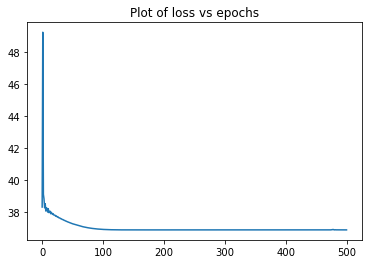

In [298]:
#  plpottiing the loss function woth epochs  
ax = sns.lineplot(np.arange(epochs), [x.item() for x in final_losses]).set_title("Plot of loss vs epochs")

In [91]:
#predition of test_pre data
y_pred = []
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred.append(model.forward(data).item())

In [92]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
from sklearn.metrics import mean_absolute_error
mse = mean_absolute_error(y_test, y_pred)

In [93]:
mse

5.481205342349706

# preparing the submission file


In [94]:
df_test = preprocess(df_test).values

In [95]:
X_test_final = torch.FloatTensor(df_test)
y_pred_final = []
with torch.no_grad():
    for i, data in enumerate(X_test_final):
        y_pred_final.append(model.forward(data).item())

In [97]:
df_submission = pd.DataFrame({"tumor_size": y_pred_final})
df_submission.to_csv( "submission.csv")

# Model saving


In [99]:
torch.save(model, "melanoma .pt")

# Model 2: xgboost

In [158]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [159]:

regressor = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear', "reg:squarederror"],
              'learning_rate': [.03, 0.05, .07, 0.1], #so called `eta` value
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [100,300, 500, 700, 1000]}
random_search = GridSearchCV(regressor,parameters, cv = 2, n_jobs = -1, verbose = True)
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 200 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.7min finished


[14:32:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:32:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8],
        

In [160]:
random_search.best_params_, random_search.best_score_

({'colsample_bytree': 0.8,
  'learning_rate': 0.03,
  'max_depth': 7,
  'min_child_weight': 4,
  'n_estimators': 300,
  'nthread': 4,
  'objective': 'reg:linear',
  'silent': 1,
  'subsample': 0.7},
 0.4189280355721074)

In [161]:
regressor = XGBRegressor(**{'colsample_bytree': 0.8,
  'learning_rate': 0.03,
  'max_depth': 7,
  'min_child_weight': 4,
  'n_estimators': 300,
  'nthread': 4,
  'objective': 'reg:linear',
  'silent': 1,
  'subsample': 0.7})
regressor.fit(X_train, y_train)

[14:33:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:33:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [162]:
y_pred_2 = regressor.predict(X_test)

In [163]:
df_test  = pd.read_csv("./dataset/test.csv")
X_test_final = preprocess(df_test).values
y_pred_final_2 = regressor.predict(X_test_final)
y_pred_final_2

array([5.173823 , 6.417707 , 3.5204356, ..., 8.52206  , 5.437678 ,
       2.3470213], dtype=float32)

In [164]:

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_2)
mae = mean_absolute_error(y_test, y_pred_2)

mse, mae

(21.07712836947775, 3.5504568039269024)

# Preparing submission file

In [151]:
df_submission = pd.DataFrame({"tumor_size": y_pred_final_2})
df_submission.to_csv( "submission.csv")

In [166]:
# model save
import joblib
regressor_xgboost = regressor
joblib.dump(regressor, "regressor_xgboost")

['regressor_xgboost']